# Experiments on toy ring data with varying dataset size

In [13]:
%env CUDA_VISIBLE_DEVICES=3
%load_ext autoreload
%autoreload 2
import numpy as np
import umap
import matplotlib.pyplot as plt
import matplotlib
from scipy.sparse import coo_matrix
from umap.my_utils import compute_low_dim_psims, get_ring, filter_graph, kNN_dists
from umap.my_plot import hists_from_graph_embd, plot_all_losses
import os
import pickle


env: CUDA_VISIBLE_DEVICES=3
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
fig_path = "../figures"
data_path = "../data/toy_ring"

data_seed = 3
umap_seed = 0

radius = 4
sig = 0.5
sig_str = "_".join(str(sig).split("."))

selected_sizes = [100, 500, 1000, 5000, 10000]

# Normal UMAP

In [ ]:
# get the data
sizes = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 5000, 7000, 8000, 10000]
datasets = []
for n in sizes:
    try:
        data = np.load(os.path.join(data_path, f"toy_ring_{n}_{radius}_{sig_str}_original_seed_{data_seed}.npy"))
    except FileNotFoundError:
        np.random.seed(data_seed)
        data = get_ring(n, radius, sig, noise="uniform")
        np.save(os.path.join(data_path,
                             f"toy_ring_{n}_{radius}_{sig_str}_original_seed_{data_seed}.npy"),
                data)
    datasets.append(data)
    if n in selected_sizes:
        fig_data = plt.figure()
        plt.scatter(*data.T,
                    s=4,
                    alpha = 0.5,
                    edgecolors="none",
                    linewidth=0)
        plt.gca().set_aspect("equal")
        plt.axis('off')
        fig_data.savefig(os.path.join(fig_path, f"toy_ring_{n}_{radius}_{sig_str}_original_seed_{data_seed}.png"),
                         bbox_inches = 'tight',
                         pad_inches = 0,
                         dpi=300)



In [42]:
# compute umap
umappers = []
for i, n in enumerate(sizes):
    try:
        with open(os.path.join(data_path, f"umapperns_toy_ring_{n}_init_10000_after_seed_{umap_seed}.pkl"), "rb") as file:
            umapper = pickle.load(file)
            umappers.append(umapper)
    except FileNotFoundError:
        umapper = umap.UMAP(random_state=umap_seed,
                              verbose=True,
                              n_epochs=10000,
                              init=datasets[i])
        umapper.fit(datasets[i])
        umappers.append(umapper)
        with open(os.path.join(data_path, f"umapperns_toy_ring_{n}_init_10000_after_seed_{umap_seed}.pkl"), "wb") as file:
            pickle.dump(umapper, file, pickle.HIGHEST_PROTOCOL)

Thu Oct 21 14:30:24 2021 Building and compiling search function
Thu Oct 21 14:30:25 2021 Building and compiling search function
Thu Oct 21 14:30:26 2021 Building and compiling search function
Thu Oct 21 14:30:28 2021 Building and compiling search function


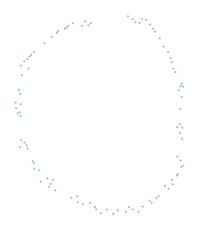

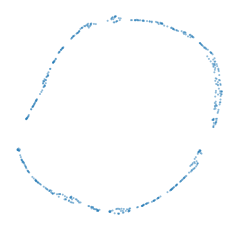

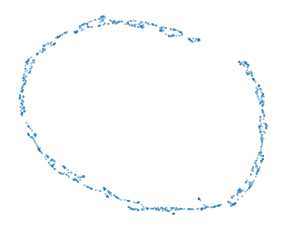

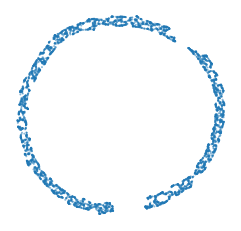

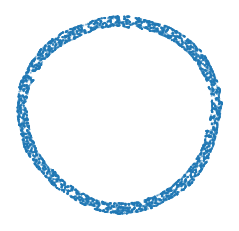

In [93]:
# plot figures
for i, umapper in enumerate(umappers):
    if sizes[i] in selected_sizes:
        plt.figure()
        plt.scatter(*umapper.embedding_.T,
                    s=4,
                    alpha = 0.5,
                    edgecolors="none",
                    linewidth=0.0)
        plt.gca().set_aspect("equal")
        plt.axis("off")

        plt.savefig(os.path.join(fig_path, f"toy_ring_n_{sizes[i]}_init_10000.png"),
                         bbox_inches = 'tight',
                         pad_inches = 0,
                         dpi=300)

#### Histograms

In [69]:
alpha=0.5
min_dist = 0.1
spread = 1.0
a, b= umap.umap_.find_ab_params(spread=spread, min_dist=min_dist)


In [70]:
# filter graph as done during the UMAP optimization
fil_graphs = []

for umapper in umappers:
    fil_graph = filter_graph(umapper.graph_, umapper.n_epochs).tocoo()
    fil_graphs.append(fil_graph)

In [72]:
# compute the histograms

histogram_data = []
for i, fil_graph in enumerate(fil_graphs):
    if sizes[i] in selected_sizes:
        hist_high, \
        hist_high_pos, \
        hist_target, \
        hist_target_pos, \
        hist_low, \
        hist_low_pos, \
        bins = hists_from_graph_embd(graph=fil_graph,
                                     embedding=umappers[i].embedding_,
                                     a=a,
                                     b=b)
        histogram_data.append([ hist_high,
                                hist_high_pos,
                                hist_target,
                                hist_target_pos,
                                hist_low,
                                hist_low_pos,
                                bins])

In [97]:
plt.rcParams.update({'font.size': 22})

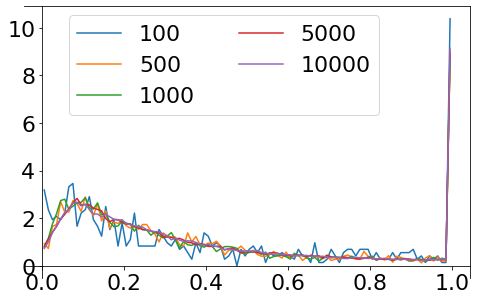

In [101]:
#plot density curve instead of histogram
plt.figure(figsize=(8,5))
for i, histogram_data_i in enumerate(histogram_data):
    plt.plot(bins[:-1]+0.005, len(bins) * histogram_data_i[1] / histogram_data_i[1].sum(),
             label=selected_sizes[i])
plt.legend(ncol=2, loc=(0.1,0.6))
plt.gca().spines['left'].set_position("zero")
plt.gca().spines['bottom'].set_position("zero")
plt.savefig(os.path.join(fig_path, f"toy_ring_sample_high_sim_{radius}_{sig_str}_{data_seed}_{umap_seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)


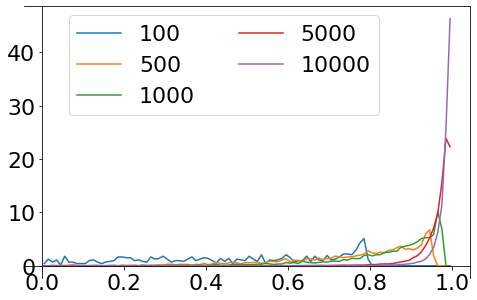

In [102]:
plt.figure(figsize=(8,5))
for i, histogram_data_i in enumerate(histogram_data):
    plt.plot(bins[:-1]+0.005, len(bins) * histogram_data_i[3] / histogram_data_i[3].sum(),
             label=selected_sizes[i])
plt.legend(ncol=2, loc=(0.1,0.6))
plt.gca().spines['left'].set_position("zero")
plt.gca().spines['bottom'].set_position("zero")
plt.savefig(os.path.join(fig_path, f"toy_ring_sample_target_sim_{radius}_{sig_str}_{data_seed}_{umap_seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)


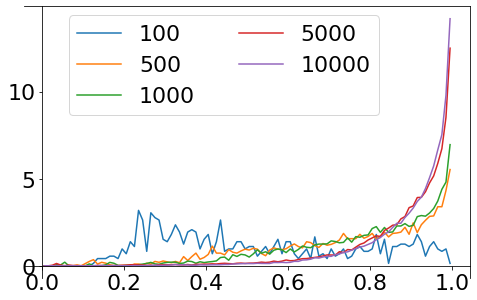

In [103]:
plt.figure(figsize=(8,5))
for i, histogram_data_i in enumerate(histogram_data):
    plt.plot(bins[:-1]+0.005, len(bins) * histogram_data_i[5] / histogram_data_i[5].sum(),
             label=selected_sizes[i])
plt.legend(ncol=2, loc=(0.1,0.6))
plt.gca().spines['left'].set_position("zero")
plt.gca().spines['bottom'].set_position("zero")
plt.savefig(os.path.join(fig_path, f"toy_ring_sample_low_sim_{radius}_{sig_str}_{data_seed}_{umap_seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)



#### zoom-in to see substructure

In [81]:
def get_zoom_section(data, max_angle):
    # center
    data_copy = data - data.mean(0)

    slope = np.tan(max_angle)

    mask1 = data_copy[:, 1] >=0
    mask2 = data_copy[:,0] * slope >= data_copy[:, 1]

    mask = mask1 * mask2
    return data[mask]


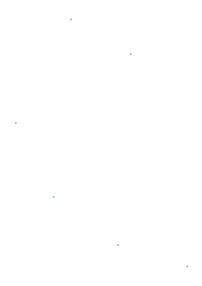

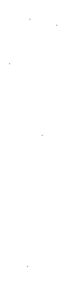

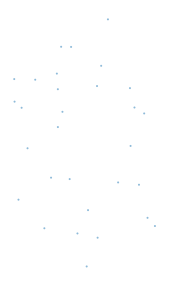

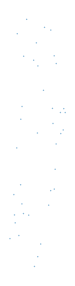

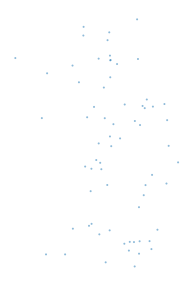

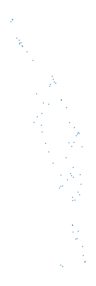

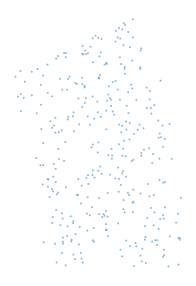

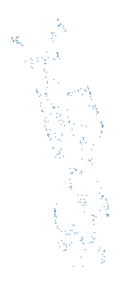

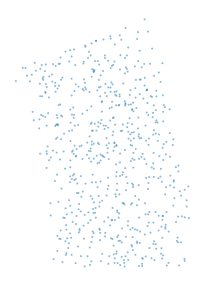

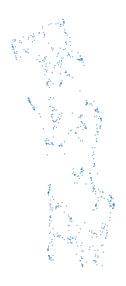

In [94]:
max_angle = np.pi / 8
data_zoom_sections = [get_zoom_section(dataset, max_angle) for dataset in datasets]
embd_zoom_sections = [get_zoom_section(umapper.embedding_, max_angle) for umapper in umappers]


for i in range(len(sizes)):
    if sizes[i] in selected_sizes:
        plt.figure(figsize=(8,5))
        plt.scatter(*data_zoom_sections[i].T,
                    s=4,
                    alpha=.5,
                    edgecolors="none",
                    linewidth=0)
        plt.gca().set_aspect("equal")
        plt.axis("off")

        plt.savefig(os.path.join(fig_path, f"toy_ring_n_{sizes[i]}_init_10000_zoom.png"),
                         bbox_inches = 'tight',
                         pad_inches = 0,
                         dpi=300)


        plt.figure(figsize=(8,5))
        plt.scatter(*embd_zoom_sections[i].T,
                    s=2,
                    alpha=.5,
                    edgecolors="none",
                    linewidth=0)
        plt.gca().set_aspect("equal")
        plt.axis("off")
        plt.savefig(os.path.join(fig_path, f"toy_ring_{sizes[i]}_{radius}_{sig_str}_original_seed_{data_seed}_zoom.png"),
                         bbox_inches = 'tight',
                         pad_inches = 0,
                         dpi=300)

In [58]:
# compute mean kNN radii
k = 15

mean_knn_radii = []
std_knn_radii = []
for i, dataset in enumerate(datasets):
    knn_dists = kNN_dists(dataset, k=k)
    knn_radii = knn_dists.cpu().numpy().max(1)
    mean_knn_radii.append(knn_radii.mean())
    std_knn_radii.append(knn_radii.std())
    print(f"Size:               {sizes[i]}")
    print(f"Mean knn radius:    {knn_radii.mean()}")
    print(f"Std def knn radius: {knn_radii.std()}")
    print("\n")

mean_knn_radii = np.array(mean_knn_radii)
std_knn_radii = np.array(std_knn_radii)

Size:               50
Mean knn radius:    3.7744180097279663
Std def knn radius: 0.2194021380359851


Size:               100
Mean knn radius:    1.9752402048366853
Std def knn radius: 0.1196871044934392


Size:               200
Mean knn radius:    1.0546044086496247
Std def knn radius: 0.08614157918880144


Size:               300
Mean knn radius:    0.7502732384635368
Std def knn radius: 0.0858056750193544


Size:               400
Mean knn radius:    0.599434024110477
Std def knn radius: 0.08081557182652802


Size:               500
Mean knn radius:    0.5406440315775385
Std def knn radius: 0.07283420985920996


Size:               600
Mean knn radius:    0.4694090799034128
Std def knn radius: 0.07296015635794766


Size:               700
Mean knn radius:    0.4361828693769938
Std def knn radius: 0.0703892577593673


Size:               800
Mean knn radius:    0.40825750852900583
Std def knn radius: 0.06860336892591631


Size:               900
Mean knn radius:    0.38004810546386

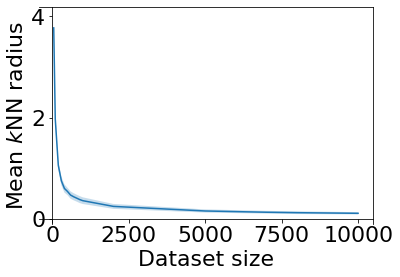

In [104]:
plt.figure()
plt.plot(sizes, mean_knn_radii)
plt.fill_between(sizes,
                mean_knn_radii-std_knn_radii,
                mean_knn_radii+std_knn_radii,
                alpha =  0.5*alpha,
                    )
plt.xlabel("Dataset size")
plt.ylabel(r"Mean $k$NN radius")
plt.gca().spines['left'].set_position("zero")
plt.gca().spines['bottom'].set_position("zero")
plt.savefig(os.path.join(fig_path, f"toy_ring_knn_radii_{radius}_{sig_str}_original_seed_{data_seed}_zoom.png"),
                 bbox_inches = 'tight',
                 pad_inches = 0,
                 dpi=300)

# Dense high-dimensional similarities

In [86]:
# get dense input similarities
min_dist = 0.1
spread = 1.0
a, b= umap.umap_.find_ab_params(spread=spread, min_dist=min_dist)


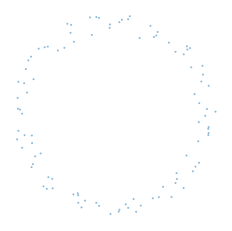

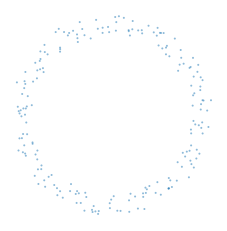

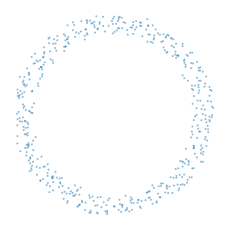

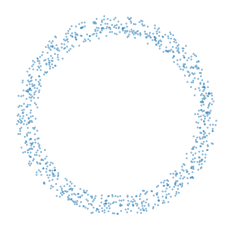

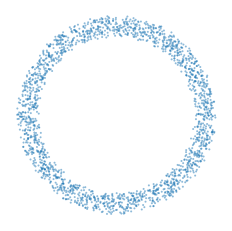

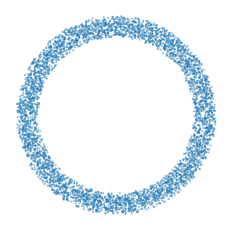

In [95]:
# get the data
sizes_graph = [100, 200, 500, 1000, 2000, 5000]
datasets_graph = []
for n in sizes_graph:
    try:
        data = np.load(os.path.join(data_path, f"toy_ring_{n}_{radius}_{sig_str}_original_seed_{data_seed}.npy"))
    except FileNotFoundError:
        np.random.seed(data_seed)
        data = get_ring(n, radius, sig, noise="uniform")
        np.save(os.path.join(data_path,
                             f"toy_ring_{n}_{radius}_{sig_str}_original_seed_{data_seed}.npy"),
                data)
    datasets_graph.append(data)
    fig_data = plt.figure()
    plt.scatter(*data.T,
                s=4,
                alpha = 0.5,
                edgecolors="none",
                linewidth=0
                )
    plt.gca().set_aspect("equal")
    plt.axis('off')
    fig_data.savefig(os.path.join(fig_path, f"toy_ring_{n}_{radius}_{sig_str}_original_seed_{data_seed}.png"),
                     bbox_inches = 'tight',
                     pad_inches = 0,
                     dpi=300)

In [29]:
low_sims_sparse = [coo_matrix(compute_low_dim_psims(data, a, b)) for data in datasets_graph]

In [30]:
# get umap embedding
umappers_graph = []
for i in range(len(sizes_graph)):
    # Initialize at input data, optimize for 10000 epochs use dense input similarities
    try:
        with open(os.path.join(data_path, f"toy_ring_{sizes_graph[i]}_{radius}_{sig_str}_umapperns_init_graph_10000_seed_{data_seed}_{umap_seed}.pkl"), "rb") as file:
            umapperns_init_graph_10000 = pickle.load(file)
    except FileNotFoundError:
        umapperns_init_graph_10000 = umap.UMAP(init=datasets[i],
                                                 graph=low_sims_sparse[i],
                                                 n_epochs=10000,
                                                 random_state=umap_seed,
                                                 verbose=True)
        umapperns_init_graph_10000.fit(datasets_graph[i])
        with open(os.path.join(data_path, f"toy_ring_{sizes_graph[i]}_{radius}_{sig_str}_umapperns_init_graph_10000_seed_{data_seed}_{umap_seed}.pkl"), "wb") as file:
            pickle.dump(umapperns_init_graph_10000, file, pickle.HIGHEST_PROTOCOL)
    umappers_graph.append(umapperns_init_graph_10000)

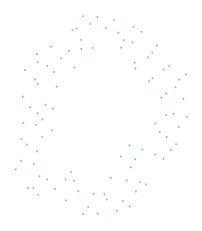

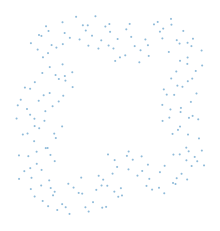

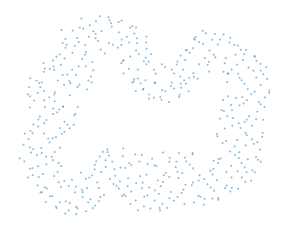

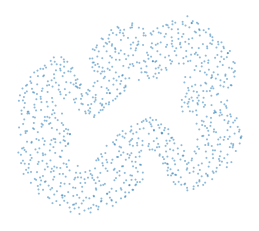

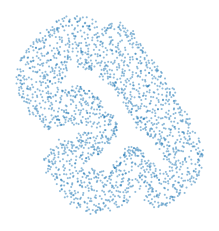

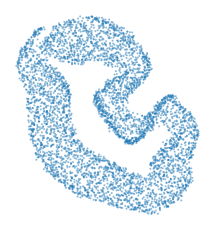

In [106]:
# plot embedding
for i, umapper in enumerate(umappers_graph):
    plt.figure()
    plt.scatter(*umapper.embedding_.T,
                s=4,
                alpha = 0.5,
                edgecolors="none",
                linewidth=0)
    plt.gca().set_aspect("equal")
    plt.axis("off")

    plt.savefig(os.path.join(fig_path, f"toy_ring_n_{sizes_graph[i]}_init_graph_10000.png"),
                     bbox_inches = 'tight',
                     pad_inches = 0,
                dpi=300)

In [107]:
# compute average degree
avg_degs = []
std_degs = []
for i, umapper in enumerate(umappers_graph):
    deg = (umapper.graph_).sum(1)
    avg_degs.append(deg.mean())
    std_degs.append(deg.std())
avg_degs = np.stack(avg_degs)
std_degs = np.stack(std_degs)

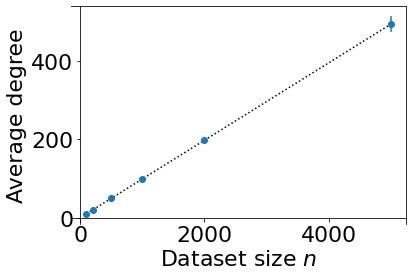

In [117]:
#plot linear dependence btw avg degree and dataset size
linear_model=np.polyfit(sizes_graph, avg_degs, 1)
linear_model_fn=np.poly1d(linear_model)

plt.figure()
plt.plot(sizes_graph,
         linear_model_fn(sizes_graph),
         linestyle="dotted",
         c="k")
plt.xlabel(r"Dataset size $n$")
plt.ylabel(r"Average degree")
plt.gca().spines['left'].set_position("zero")
plt.gca().spines['bottom'].set_position("zero")
plt.errorbar(sizes_graph, avg_degs, yerr=std_degs, fmt="o")
plt.savefig(os.path.join(fig_path, f"toy_ring_init_graph_10000_avg_deg.png"),
                 bbox_inches = 'tight',
                 pad_inches = 0,
                 dpi=300)